# Exploring Business Improvement Areas in Toronto Using Data

According to the city of Toronto, a Business Improvement Area (BIA) is an "association of commercial property owners and tenants within a defined area who work in partnership with the City to create thriving, competitive, and safe business areas that attract shoppers, diners, tourists, and new businesses". The goal of this project is to leverage data to aid commercial property owners and tenants with the process of defining new BIA's based on the location and tpy eof businesses in the city.

For this project, I used three datasets from the City of Toronto, implemented a Machine Learning algorithm from a research paper, and used the Foursquare Places API to take a detailed view of the location and types of businesses in Toronto. I looked at clusters of venues outside existing BIA's, compared them to venues inside existing BIA's, and found some interesting patterns that might help with the development of new BIA's.

## Import the necessary libraries

In [609]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))  # fill cell width to screen

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import scipy as sp
import math
import random
import itertools
import time

from concurrent import futures  # parallel processes

from scipy.spatial import distance  # distance matrix computations
from scipy.cluster import hierarchy  # hierarchical clustering

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler  # used to normalize data
from sklearn import svm

import networkx as nx  # plot graphs

import requests  # handle requests
import json

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import plotly.express as px
import pylab  # plotting dendograms
import seaborn as sns  # plotting in general
import branca  # add legend to folium map
import folium  # map rendering library

import geopandas  # DataFrame to GeoJSON
import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon  # create shapely geometry objects
from functools import partial
from haversine import haversine_vector  # calculate distance between coordinates in lat, long

import warnings

## Read Vehicle and Pedestrian Volumes from the Open Data Toronto Catalogue
The dataset contains the 8 peak hour vehicle and pedestrian volume counts collected at intersections where there are traffic signals. The data was collected between the hours of 7:30 a.m. and 6:00 p.m. It is worth noting that for each intersection, the data was collected on a single day is not an average of multiple days. This is a limitation of the data, but it is still useful since I will be looking at the pedestrian volume of neighbourhoods by grouping intersections. Therefore, they will be averaged and any discrepancy in data collection will be minimized. Furthermore, I am interested in the busiest neighbourhoods and, on a typical day, there will be a vast difference in pedestrian volume between the busiest neighbourhoods and the less busy ones.

In [610]:
# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
payload = {"id": "ae4e10a2-9eaf-4da4-83fb-f3731a30c124"}
response = requests.get(url, params=payload).json()
traffic_df = pd.read_excel(response["result"]['resources'][0]['url'])
print('Number of rows read in:', traffic_df.shape[0], '\n')
traffic_df.head()

Number of rows read in: 2280 



TCS #       Main Midblock Route   Side 1 Route Side 2 Route  \
0      2  JARVIS ST            NaN     FRONT ST E          NaN   
1      3  KING ST E            NaN      JARVIS ST          NaN   
2      4  JARVIS ST            NaN  ADELAIDE ST E          NaN   
3      5  JARVIS ST            NaN  RICHMOND ST E          NaN   
4      6  JARVIS ST            NaN     QUEEN ST E          NaN   

  Activation Date   Latitude  Longitude Count Date  8 Peak Hr Vehicle Volume  \
0      11/15/1948  43.649418 -79.371446 2017-06-21                     15662   
1      08/23/1950  43.650461 -79.371924 2016-09-17                     12960   
2      09/12/1958  43.651534 -79.372360 2016-11-08                     17770   
3      04/21/1962  43.652718 -79.372824 2015-12-08                     19678   
4      08/24/1928  43.653704 -79.373238 2016-09-17                     14487   

   8 Peak Hr Pedestrian Volume  
0                        13535  
1                         7333  
2                         7083  
3                         4369  
4                         3368

## Traffic data cleaning

Visualize the columns of the table and see if there are any missing values. Non-missing values will be coloured black, while missing values will be white. Also, check for duplicate intersections using their latitude and longitude values.

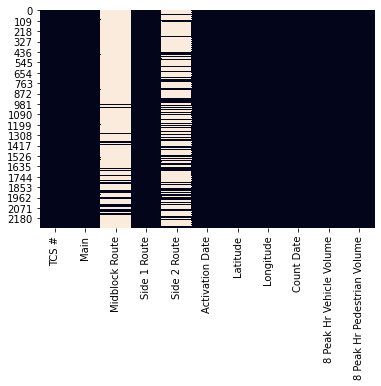

In [611]:
sns.heatmap(traffic_df.isnull(), cbar=False)

In [612]:
print('Number of unique latitude and longitude values:', len(traffic_df.groupby(['Latitude', 'Longitude']).size()))
print('Number of rows in the table:', traffic_df.shape[0], '\n')

Number of unique latitude and longitude values: 2280
Number of rows in the table: 2280 



There are missing values in two of the columns that define an intersection. However, I am only interested in the geographical location of the intersections, as well as their pedestrian and vehicle volumes so these two columns can be removed. Additionally, the count and activation dates are not needed for the purpose of this project so they will be removed as well. Finally, the vehicle volume gets removed given that in the busiest neighbourhoods of the city (i.e. downtown) most people are either driving through or driving to work and not driving to a venue in specific. The remaining columns are renamed to make the table easier to work with

In [613]:
col_rename = {
    'TCS #': 'Id',
    'Side 1 Route': 'Side1',
    '8 Peak Hr Pedestrian Volume': 'PedestrianVolume'}
traffic_df.drop(['Midblock Route', 'Side 2 Route', '8 Peak Hr Vehicle Volume', 'Activation Date', 'Count Date'], axis=1, inplace=True)
traffic_df.rename(columns=col_rename, inplace=True)

# add column with the intersection name
intersections = traffic_df.loc[:, 'Main'] + ' & ' + traffic_df.loc[:, 'Side1']
traffic_df.loc[:, 'Intersection'] = intersections

traffic_df.head()

Id       Main          Side1   Latitude  Longitude  PedestrianVolume  \
0   2  JARVIS ST     FRONT ST E  43.649418 -79.371446             13535   
1   3  KING ST E      JARVIS ST  43.650461 -79.371924              7333   
2   4  JARVIS ST  ADELAIDE ST E  43.651534 -79.372360              7083   
3   5  JARVIS ST  RICHMOND ST E  43.652718 -79.372824              4369   
4   6  JARVIS ST     QUEEN ST E  43.653704 -79.373238              3368   

                Intersection  
0     JARVIS ST & FRONT ST E  
1      KING ST E & JARVIS ST  
2  JARVIS ST & ADELAIDE ST E  
3  JARVIS ST & RICHMOND ST E  
4     JARVIS ST & QUEEN ST E

Take a look at the descriptive statistics of the table to see if any further cleaning is necessary.

In [614]:
traffic_df.describe()

Id     Latitude    Longitude  PedestrianVolume
count  2280.000000  2280.000000  2280.000000       2280.000000
mean   1155.409649    43.713472   -79.394597       1990.127193
std     678.773805     0.056042     0.164106       3984.960526
min       2.000000    43.591686   -79.639290          0.000000
25%     572.750000    43.664934   -79.475263        280.000000
50%    1142.500000    43.709355   -79.396512        712.000000
75%    1722.250000    43.760777   -79.317662       1700.250000
max    3014.000000    43.855450   -73.389642      47561.000000

We see that there is at least one intersection where the pedestrian volume is zero. We don't want to consider intersections where there is no pedestrian traffic since they're likely to be highway ramps and the likelihood of a business being at these intersections is low.

In [615]:
orig_rows = traffic_df.shape[0]
traffic_df.drop(traffic_df[traffic_df['PedestrianVolume'] == 0].index, inplace=True)
traffic_df.reset_index(inplace=True, drop=True)
new_rows = traffic_df.shape[0]
print('Number of rows with 0 pedestrian traffic that were dropped:', orig_rows - new_rows)

Number of rows with 0 pedestrian traffic that were dropped: 12


The plot below shows a scatter plot of the latitudes and longitudes in the data. This should have roughly the shape of the city, but we see that there is an outlier to the right of -74 degrees of longitude. Let's take a look at this entry and see what the data looks like.

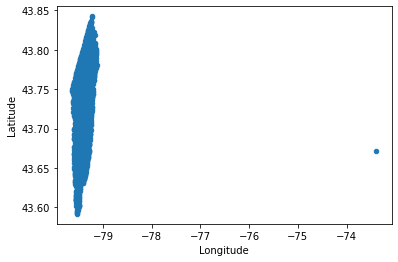

In [616]:
traffic_df.plot(kind='scatter', x='Longitude', y='Latitude')

In [617]:
traffic_df.loc[traffic_df['Longitude'] > -74]

Id      Main          Side1   Latitude  Longitude  PedestrianVolume  \
2250  2377  YONGE ST  YORKVILLE AVE  43.671923 -73.389642              5014   

                  Intersection  
2250  YONGE ST & YORKVILLE AVE

If you search the intersection in Google Maps, you will see that it is in the downtown area. The longitude value was recorded incorrectly and its correct value is -79.3874532, so it needs to be corrected.

In [618]:
traffic_df.loc[traffic_df['Id'] == 2377, 'Longitude'] = -79.3874532
traffic_df.loc[traffic_df['Id'] == 2377]

Id      Main          Side1   Latitude  Longitude  PedestrianVolume  \
2250  2377  YONGE ST  YORKVILLE AVE  43.671923 -79.387453              5014   

                  Intersection  
2250  YONGE ST & YORKVILLE AVE

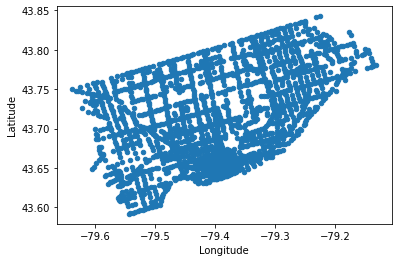

In [619]:
traffic_df.plot(kind='scatter', x='Longitude', y='Latitude');

You can see that the plot now resembles the shape of the city. Below are histograms of the numerical data in the table and there doesn't seem to be any large outliers so no more cleaning is needed for now.

In [620]:
traffic_df.hist(figsize=(8,8));

Error in callback <function flush_figures at 0x00000237DDEA8B88> (for post_execute):


KeyboardInterrupt: 

## Read Neighbourhood Profiles from the Open Data Toronto Catalogue
Neighbourhoods in Toronto refer to the city's 140 social planning neighbourhoods. These social planning neighbourhoods help government and community organizations with local planning by providing socio-economic data at a meaningful geographic data. We are interested in the boundaries of these neighbourhoods, which remain consisten over time. The data is sourced by Statistics Canada. To read more about neighbourhood profiles, visit its Open Data Toronto page at https://open.toronto.ca/dataset/neighbourhood-profiles/.

In [621]:
nbh_gdf = geopandas.read_file('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15?format=geojson&projection=4326')
print('Number of rows read in:', nbh_gdf.shape[0])
nbh_gdf.head()

Number of rows read in: 140


_id   AREA_ID  AREA_ATTR_ID  PARENT_AREA_ID  AREA_SHORT_CODE  \
0  6301  25886861      25926662           49885               94   
1  6302  25886820      25926663           49885              100   
2  6303  25886834      25926664           49885               97   
3  6304  25886593      25926665           49885               27   
4  6305  25886688      25926666           49885               31   

   AREA_LONG_CODE                     AREA_NAME                     AREA_DESC  \
0              94                 Wychwood (94)                 Wychwood (94)   
1             100          Yonge-Eglinton (100)          Yonge-Eglinton (100)   
2              97           Yonge-St.Clair (97)           Yonge-St.Clair (97)   
3              27  York University Heights (27)  York University Heights (27)   
4              31       Yorkdale-Glen Park (31)       Yorkdale-Glen Park (31)   

      X     Y  LONGITUDE   LATITUDE  OBJECTID   Shape__Area  Shape__Length  \
0  None  None -79.425515  43.676919  16491505  3.217960e+06    7515.779658   
1  None  None -79.403590  43.704689  16491521  3.160334e+06    7872.021074   
2  None  None -79.397871  43.687859  16491537  2.222464e+06    8130.411276   
3  None  None -79.488883  43.765736  16491553  2.541821e+07   25632.335242   
4  None  None -79.457108  43.714672  16491569  1.156669e+07   13953.408098   

                                            geometry  
0  POLYGON ((-79.43592 43.68015, -79.43492 43.680...  
1  POLYGON ((-79.41096 43.70408, -79.40962 43.704...  
2  POLYGON ((-79.39119 43.68108, -79.39141 43.680...  
3  POLYGON ((-79.50529 43.75987, -79.50488 43.759...  
4  POLYGON ((-79.43969 43.70561, -79.44011 43.705...

I'm only interested in the location and shape (geometry) of each neighbourhood, so all other columns are removed and the remaining ones renamed.

In [622]:
nbh_gdf.drop(labels=['_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_SHORT_CODE',
                              'AREA_LONG_CODE', 'AREA_DESC', 'X', 'Y', 'OBJECTID',
                              'Shape__Area', 'Shape__Length'], axis=1, inplace=True)
nbh_gdf.rename(columns={'AREA_NAME': 'Neighbourhood',
                        'LATITUDE': 'Latitude',
                        'LONGITUDE': 'Longitude'}, inplace=True)

nbh_clean = nbh_gdf['Neighbourhood'].str.replace(r"\(.*\)","").str.strip().to_list()

nbh_gdf.loc[:, 'Neighbourhood'] = nbh_clean

nbh_gdf.head()

Neighbourhood  Longitude   Latitude  \
0                 Wychwood -79.425515  43.676919   
1           Yonge-Eglinton -79.403590  43.704689   
2           Yonge-St.Clair -79.397871  43.687859   
3  York University Heights -79.488883  43.765736   
4       Yorkdale-Glen Park -79.457108  43.714672   

                                            geometry  
0  POLYGON ((-79.43592 43.68015, -79.43492 43.680...  
1  POLYGON ((-79.41096 43.70408, -79.40962 43.704...  
2  POLYGON ((-79.39119 43.68108, -79.39141 43.680...  
3  POLYGON ((-79.50529 43.75987, -79.50488 43.759...  
4  POLYGON ((-79.43969 43.70561, -79.44011 43.705...

Check for any missing data, and see if the column types are appropriate.

Neighbourhood      object
Longitude         float64
Latitude          float64
geometry         geometry
dtype: object


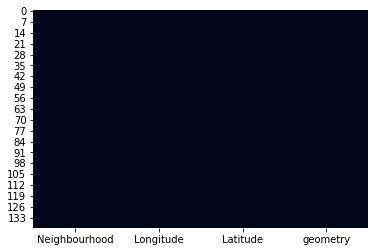

In [623]:
sns.heatmap(nbh_gdf.isnull(), cbar=False)

print(nbh_gdf.dtypes)

There is no missing data, and the column types make sense. Now check for duplicates.

In [624]:
print('Are there any duplicate neighbourhoods:', nbh_gdf.shape[0] != len(nbh_gdf.groupby(['Latitude', 'Longitude']).size()))

Are there any duplicate neighbourhoods: False


I would like to have the area of each neighbourhood, so I will transform the projection of the polygon to an _equal area projection_ in order to get their area in squared kilometers.

In [625]:
nbh_proj = nbh_gdf.loc[:, ('Neighbourhood', 'geometry')]
with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        nbh_proj = nbh_proj.to_crs({'proj': 'cea'})
nbh_proj['Area'] = nbh_proj.loc[:, 'geometry'].area / 10**6
nbh_proj.drop('geometry', axis=1, inplace=True)
nbh_gdf = nbh_gdf.merge(nbh_proj.set_index('Neighbourhood'), on='Neighbourhood')
nbh_gdf.head()

Neighbourhood  Longitude   Latitude  \
0                 Wychwood -79.425515  43.676919   
1           Yonge-Eglinton -79.403590  43.704689   
2           Yonge-St.Clair -79.397871  43.687859   
3  York University Heights -79.488883  43.765736   
4       Yorkdale-Glen Park -79.457108  43.714672   

                                            geometry       Area  
0  POLYGON ((-79.43592 43.68015, -79.43492 43.680...   1.682722  
1  POLYGON ((-79.41096 43.70408, -79.40962 43.704...   1.651070  
2  POLYGON ((-79.39119 43.68108, -79.39141 43.680...   1.161741  
3  POLYGON ((-79.50529 43.75987, -79.50488 43.759...  13.252506  
4  POLYGON ((-79.43969 43.70561, -79.44011 43.705...   6.040847

## Mapping Neighbourhoods and Intersections
It is helpful to visualize the neighbourhoods and the intersections together, so I created a map that overlays both datasets on top of a map of Toronto.

In [626]:
# define centre latitude and longitude for the city
centre_lat = 43.7064
centre_lng = -79.3986

In [627]:
def FitZoomBounds(m, latitudes, longitudes, offset=0):
    # Function to get the coordinates for the bounding box that defines the level of zoom in a
    # folium map.
    #
    # Args:
    #   m: folium Map object
    #   latitudes: array of latitude values.
    #   longitudes: array of longitude values.
    #   offset: proportion of the maximum latitude and longitude used to offset the bounding box
    #           corners. Positive number to contract the box, negative number to dilate the box.
    #
    # Returns: None
    
    min_lat, max_lat = latitudes.min(), latitudes.max()
    min_lng, max_lng = longitudes.min(), longitudes.max()
    max_lat_pct = max_lat * offset
    max_lng_pct = max_lng * -offset
    sw = [min_lat + max_lat_pct, min_lng + max_lng_pct]
    ne = [max_lat - max_lat_pct, max_lng - max_lng_pct]
    
    m.fit_bounds([sw, ne])

    return


def CreateMap(centre_lat, centre_lng, **kwargs):
    # Function to create a Folium Map Object.
    #
    # Args:
    #   centre_lat: latitude value of the centre of the map
    #   centre_lng: longitude value of the centre of the map
    #   **kwargs: addtional keyword arguments passed to folium class folium.folium.Map
    #
    # Returns:
    #   m: a Folium Map Object
    
    m = folium.Map(
        location=[centre_lat, centre_lng],
        **kwargs
    )
    
    return m


def AddCircleMarkers(m, latitudes, longitudes, labels, **kwargs):
    # Function to add circle markers to the folium Map m.
    #
    # Args:
    #   m: folium Map object
    #   latitudes: list of latitude values to plot
    #   longitudes: list of longitude values to plot; must be same length as latitudes
    #   labels: labels for the markers; must be same length as latitudes
    #   **kwargs: additional keyword arguments passed to the folium class
    #             folium.vector.layers.CircleMarker
    #
    # Returns: None
    
    for lat, lng, label in zip(latitudes,
                               longitudes,
                               labels):

        folium.Circle(
            [lat, lng],
            popup=label,
            **kwargs
        ).add_to(m)
        
    return


def AddPolygonLayer(m, gdf, return_layer=False, **kwargs):
    # Function to add a GeoJson layer to a folium Map object.
    #
    # Args:
    #   m: folium Map object
    #   gdf: GeoDataFrame with geometry data for the GeoJson layer
    #   return_layer: True if the GeoJson layer is to be returned, otherwise do nothing
    #   **kwargs: additional keyword arguments passed to the folium class folium.features.GeoJson
    #
    # Returns:
    #    geo_layer, if return_layer = True

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        geo_layer = folium.GeoJson(gdf, **kwargs).add_to(m)

    if return_layer:
        return geo_layer

In [628]:
m = CreateMap(centre_lat, centre_lng, zoom_start=11, scrollWheelZoom=False)

AddPolygonLayer(m, nbh_gdf)

AddCircleMarkers(m, traffic_df['Latitude'], traffic_df['Longitude'], traffic_df['Intersection'],
                 radius=3, color='black', weight=3)
                 
FitZoomBounds(m, traffic_df['Latitude'], traffic_df['Longitude'], 0.0002)

m

We see that the boundaries of each neighbourhood are well defined, and they fit well within the boundaries of the city. The next step is to associate each intersection with the neighbourhood they are in, and explore the busiest neighbourhoods.

## Assign Intersections to their Neighbourhoods
The goal here is to assign each intersection to a neighbourhood and then we can see which neighbourhoods are the busiest in terms of pedestrian volume. In order to check that an intersection is inside a neighbourhood, we will use the _shapely_ library which allows us to check if a point is inside a geometry object.

In [629]:
def GetNbhForPoints(nbh_names, nbh_polygons, point_ids, points, point_id_name='Id', col_name='Neighbourhood'):
    # Function to get the neighbourhoods that contain each point.
    #
    # Args:
    #   nbh_names: Series of neighbourhood names
    #   nbh_polygons: geopandas.GeoSeries of shapely.geometry.Polygon objects that correspond to each 
    #                 neighbourhood in nbh_names
    #   point_ids: list of IDs for each point in points
    #   points: geopandas.GeoSeries of shapely.geometry.Point objects
    #   point_id_name: the name of the ID column in the DataFrame that will be returned
    #   col_name: string, the name of the resulting column
    #
    # Returns:
    #    point_nbh_df: DataFrame, the first column is the unique ID of the Point, and the second
    #                  column is the neighbourhood that contains the Point
    
    point_nbh_names = []
    for point in points:
        # list of booleans, True if polygon fully contains the point, False otherwise
        t = nbh_polygons.contains(point)

        # index of the list that contains the value True
        idx = np.where(t)

       # assign the area name if it was a match
        if len(idx[0]) == 1:
            nbh_name = nbh_names[idx[0][0]]
        elif len(idx[0]) > 1:
            # there are overlapping polygons that contain the point, so we'll choose the smallest polygon
            overlap_poly = nbh_polygons[idx[0]]
            nbh_name = nbh_names[overlap_poly.index.values[np.argmin(overlap_poly.area)]]
        else:
            nbh_name = 'Undefined'

        point_nbh_names.append(nbh_name)
        
    point_nbh_df = pd.DataFrame(np.array([point_ids, point_nbh_names]).T,
                               columns=[point_id_name, col_name])
    
    return point_nbh_df

In [630]:
# create a geometry column for the intersections
points_list = [Point(lng, lat) for lng, lat in zip(traffic_df['Longitude'], traffic_df['Latitude'])]
traffic_df['geometry'] = points_list

# assign the neighbourhoods
point_nbh_df = GetNbhForPoints(nbh_gdf['Neighbourhood'], nbh_gdf['geometry'], 
                               traffic_df.index.values, traffic_df['geometry'])

traffic_df = traffic_df.merge(point_nbh_df, how='inner', left_index=True, right_index=True)
traffic_df.drop('Id_y', axis=1, inplace=True)
traffic_df.rename(columns={'Id_x': 'Id'}, inplace=True)

In the function GetNbhForPoints, intersections are assigned a neighbourhood with the name 'Undefined' if the polygon didn't fully contain the point. Below is a plot of the intersections with no neighbourhood assigned to them.

In [631]:
traffic_df.loc[traffic_df['Neighbourhood'] == 'Undefined']['Neighbourhood'].value_counts()

Undefined    65
Name: Neighbourhood, dtype: int64

In [632]:
undef_nbh = traffic_df.loc[traffic_df['Neighbourhood'] == 'Undefined']

m = CreateMap(centre_lat, centre_lng, zoom_start=10, scrollWheelZoom=False)

AddPolygonLayer(m, nbh_gdf)

AddCircleMarkers(m, undef_nbh['Latitude'], undef_nbh['Longitude'],
                 undef_nbh['Intersection'], radius=3, color='black', weight=3)

FitZoomBounds(m, undef_nbh['Latitude'], undef_nbh['Longitude'], 0.0002)

m

From the map above, we see that the intersections with no assigned neighbourhood are located at the borders of their respective neighbourhood. In order to assign them their correct neighbourhood, we will determine the closest neighbourhood to each intersection and use that one.

In [633]:
def ReplaceUndefinedPoly(points_df, poly_gdf, poly_col, max_dist=0):
    # Function to find and assign the closest neighbourhood to points that have an undefined
    # neighbourhood.
    #
    # Args:
    #   points_df: DataFrame or geopandas.GeoDataFrame that contains points with neighbourhoods
    #              assigned to them. Must have the column 'geometry' of shapely.Point objects. Must
    #              have a column with the name specified by poly_col.
    #   poly_gdf: geopandas.DataFrame that contains the polygons. Must have the column 'geometry' of 
    #             shapely.Polygon objects. Must have a column called poly_col.
    #   poly_col: string, column name in points_df of the column with names of the polygons that
    #             correspond to the polygons in poly_gdf
    #   max_dist: float, maximum distance away from the polygon to be considered inside the polygon
    #
    # Effects:
    #   Modifies the 'Neighbourhood' column of points_df.
    #
    # Returns: None
    
    assert max_dist >= 0, 'The value of max_dist must be >= 0'
    assert poly_col in points_df.columns, 'There is no "' + poly_col + '" column in points_df'
    assert poly_col in poly_gdf.columns, 'There is no "' + poly_col + '" column in poly_gdf'
    
    undef_nbh = points_df.loc[points_df[poly_col] == 'Undefined']
    
    if undef_nbh.shape[0] == 0:
        warnings.warn("There are no 'Undefined' neighbourhoods. DataFrame will remain unchanged.")
        return
    
    for idx, point in zip(undef_nbh.index, undef_nbh['geometry']):
        if max_dist == 0:
            # find the closest Polygon to the point
            closest_poly = min(poly_gdf['geometry'], key=point.distance)
            
        else:
            d = poly_gdf.geometry.distance(point)
            d = d[d <= max_dist]
            
            if len(d) == 0:
                continue
                
            closest_poly = poly_gdf['geometry'][d.index[np.argmin(d)]]
            
        # get the area name for the closest Polygon
        poly_name = poly_gdf.iloc[list(poly_gdf.geometry.values).index(closest_poly)][poly_col]   

        points_df.at[idx, poly_col] = poly_name
    
    return

In [634]:
ReplaceUndefinedPoly(traffic_df, nbh_gdf, 'Neighbourhood')

# check that there are no 'Undefined' area names
print("Number of 'Undefined' Neighbourhoods:", 
      traffic_df.loc[traffic_df['Neighbourhood'] == 'Undefined'].shape[0], '\n')
    
# check that the area names were assigned
traffic_df.loc[traffic_df.index.isin(undef_nbh.index)][['Intersection', 'Neighbourhood']].head()

Number of 'Undefined' Neighbourhoods: 0 



Intersection                   Neighbourhood
129             YONGE ST & STEELES AVE                Newtonbrook East
533            STEELES AVE W & JANE ST         York University Heights
675        STEELES AVE W & BATHURST ST                Newtonbrook West
921  RENFORTH DR & RENFORTH 427 S RAMP  Eringate-Centennial-West Deane
930          STEELES AVE E & LESLIE ST           Bayview Woods-Steeles

Now every intersection belongs to a neighbourhood, so now we can determine which neighbourhoods are the busiest. We want to visualize the neighbourhoods based on their pedestrian volume in order to choose a region with the highest volume. This will allow us to choose an area of interest that we'll use for retrieving venues.

## The Busiest Neighbourhoods in the City
First, we need to get the average pedestrian volume in each neighbourhood and transform that table into a GeoDataFrame in order to create a Choropleth map. The Choropleth map will allow us to visualize the pedestrian volume in each neighbourhood by colouring the busiest neighbourhoods with a darker shade.

In [635]:
nbh_df = traffic_df.groupby('Neighbourhood')['PedestrianVolume'].mean().reset_index(name='AvgPedestrianVolume')
nbh_df.loc[:, 'AvgPedestrianVolume'] = np.round(nbh_df.loc[:, 'AvgPedestrianVolume'], 2)

# get the geometry of every neighbourhood
nbh_df = nbh_df.merge(nbh_gdf[['Neighbourhood', 'geometry']].set_index('Neighbourhood'),
                        how='inner', on='Neighbourhood')

# convert to a GeoDataFrame so we can convert it to a GeoJSON for the Choropleth map
nbh_plot_gdf = geopandas.GeoDataFrame(nbh_df)

# add Coordinate Reference System for consistency
nbh_plot_gdf.crs = {'init': 'epsg:4326'}

nbh_plot_gdf.head()

Neighbourhood  AvgPedestrianVolume  \
0               Agincourt North               805.60   
1  Agincourt South-Malvern West               683.21   
2                     Alderwood               212.82   
3                         Annex              5027.00   
4             Banbury-Don Mills               799.48   

                                            geometry  
0  POLYGON ((-79.24213 43.80247, -79.24319 43.802...  
1  POLYGON ((-79.25498 43.78122, -79.25797 43.780...  
2  POLYGON ((-79.54866 43.59022, -79.54876 43.590...  
3  POLYGON ((-79.39414 43.66872, -79.39588 43.668...  
4  POLYGON ((-79.33055 43.73979, -79.33044 43.739...

In [636]:
# convert DataFrame to GeoJSON file in order to use it in the Choropleth map
nbh_plot_gdf.to_file('neighbourhood_pedestrian_vol.json', driver='GeoJSON')
neighbourhood_geo = r'neighbourhood_pedestrian_vol.json'

KeyboardInterrupt: 

Now that we have a GeoJSON file with the neighbourhood and average pedestrian volume data, we can go ahead and create the Choropleth map. But first, let's look at the distribution of the average pedestrian volume across the neighbourhoods.

In [ ]:
_ = nbh_plot_gdf[['AvgPedestrianVolume']].plot(kind='hist', bins=50)

From the plot above, we see that the distribution of the average pedestrian volume has a long tail. We want a linear distribution in order to get a better idea of which are the busiest neighbourhoods from the plot. In order to do so, we'll just take the log of the data.

In [ ]:
log_avg_ped_vol = np.log(nbh_plot_gdf['AvgPedestrianVolume'])
_ = plt.hist(log_avg_ped_vol)

Now that the distribution looks better, let's create the Choropleth map using the log data. In the map below, you can use your mouse to hover over each neighbourhood and see its name along with the average pedestrian volume in that neighbourhood.

In [ ]:
# function by ox-baloo on https://github.com/python-visualization/folium/issues/1052
def folium_del_legend(choropleth):
    # remove choropleth legend
    del_list = []
    for child in choropleth._children:
        if child.startswith('color_map'):
            del_list.append(child)
    for del_item in del_list:
        choropleth._children.pop(del_item)
    return choropleth

In [ ]:
# add the column to the table so it can be used in folium.Choropleth
nbh_plot_gdf.loc[:, 'LogAvgPedestrianVolume'] = log_avg_ped_vol

m = CreateMap(centre_lat, centre_lng, zoom_start=11, tiles='cartodbpositron', control_scale=True,
             scrollWheelZoom=False)

c = folium.Choropleth(
    geo_data=neighbourhood_geo,
    name='Average Pedestrian Volume in Toronto Neighbourhoods',
    data=nbh_plot_gdf,
    columns=['Neighbourhood', 'LogAvgPedestrianVolume'],
    key_on='feature.properties.Neighbourhood',
    fill_color='YlOrRd',
    fill_opacity=0.9,
    line_opacity=0.2,
    highlight=True
).add_to(m)

folium_del_legend(c).add_to(m)

# add custom legend, had to use '.' in caption because the function deletes all whitespace characters
# not possible to remove the numbers from the legend unfortunately
cmap = plt.cm.get_cmap('YlOrRd')
color_list = cmap(np.arange(cmap.N))
leg = branca.colormap.LinearColormap(
    colors=['#ffffcc','#fd863a', '#8d0026'],
    caption='Less Busy ' + ''.join([char * 90 for char in '.']) +' Busiest')
leg.add_to(m)

# polygon map layer, with invisible colors
style_function = lambda x: {'fillColor': '#00000000', 'color': '#00000000'}
geo_layer = AddPolygonLayer(m, nbh_plot_gdf, return_layer=True, style_function=style_function)

# add the tooltip for mouse hover
folium.GeoJsonTooltip(['Neighbourhood', 'AvgPedestrianVolume']).add_to(geo_layer)
geo_layer.add_to(m)

m

As you can see from the map above, the busiest neighbourhoods are in the city centre and it's immediate surrounding areas. Now, we will choose the top 10 busiest neighbourhoods in order to define an area of the city where we would like to explore BIAs and venues. Below is a plot of the busiest neighbourhoods.

In [ ]:
busiest_nbh = nbh_plot_gdf.sort_values('AvgPedestrianVolume', ascending=False).head(10)

m = CreateMap(centre_lat, centre_lng, zoom_start=11, scrollWheelZoom=False)

geo_layer = AddPolygonLayer(m, busiest_nbh, return_layer=True)

# add the tooltip for mouse hover
folium.GeoJsonTooltip(['Neighbourhood', 'AvgPedestrianVolume']).add_to(geo_layer)
geo_layer.add_to(m)

m

## Retrieving Venues in the Area of Interest
Now that we have chosen a subset of neighbourhoods, the goal is to retrieve venue information in the area defined by the bounding box that contains all the neighbourhoods. To accomplish that, we will use the Foursquare Places API which allows us to get venue data for different types of businesses.
<br><br>
To get venue data for a specific area, we have to provide a set of coordinates and a numeric value that define a circle's centre and radius, respectively. The API then searches for venues inside the area defined by the circle. Unfortunately, you can only retrieve a maximum of 100 venues per API call; thus, it isn't possible to get all the venues in the city by providing a circle the size of our area of interest. To get past this limitation, there were two solutions I considered. The first one, was to keep making the same API call over and over again until the maximum amount allowed, with the hope that each time I would get a significantly different set of 100 venues. This didn't seem like a good idea to me since there was no way to guarantee that the venues would be equally distributed accross the city (e.g. there was the possibility that by chance none of the venues in a part of the city would be returned). The second solution, and the one that I implemented, involves creating a set of small, sometimes overlapping circles that cover the whole area of interest. Then you can make one API call in each circle and get the venues inside the small area defined by the cirle. The key is to define the circles small enough that it's plausible that 100 or less venues exist within that area. This way, we can get a much better distribution of venues in the city.
<br><br>
In this section, I will show how the circles were defined by creating a set of uniformly distributed points inside the bounding box and then implementing a _k_-Center Clustering algorithm to get circle centres given a fixed radius.

In [ ]:
def GetUnifRect(C, n):
    # Function to get n uniformly distributed points bounded by the rectangle given by C.
    #
    # Args:
    #   C: 2x4 matrix where each column specifies the (x, y) coordinates of the corners of the
    #      rectangle in this order: bottom-left, top-left, top-right, bottom-right
    #   n: int, number of points to fill the square with
    #
    # Returns:
    #   unif_points: 2xn matrix where each column is the (x, y) coordinate of each point
    
    # get n point uniformly distributed in the unit square
    x = np.random.uniform(0, 1, n)
    y = np.random.uniform(0, 1, n)
    U = np.vstack((x, y))
    
    # scale factors
    s_x = (C[:1, 2] - C[:1, 0])[0]
    s_y = (C[1:2, 1] - C[1:2, 0])[0]

    # scaling matrix
    S = np.vstack(([s_x, 0], [0, s_y]))
    
    # translation column
    t = np.array([C[:, 0][0], C[:, 0][1]])[:, None]
    
    # new points scaled and translated
    U_new = np.matmul(S, U) + t
    
    return U_new

In [ ]:
def GetBoundingBox(polygons):
    # Function to get the bounding box of a group of polygons.
    #
    # Args:
    #   polygons: pandas.Series of shapely.Polygon or shapely.MultiPolygon objects
    #
    # Returns:
    #   sw, nw, ne, se: latitude and longitude values of the southwest, northwest, northeast, and 
    #                   southeast corners of the bounding box, respectively.
    
    # we want the minimum latitudes and longitudes across all polygons to create the box corners
    min_lng = np.min(polygons.bounds['minx'])
    max_lng = np.max(polygons.bounds['maxx'])
    min_lat = np.min(polygons.bounds['miny'])
    max_lat = np.max(polygons.bounds['maxy'])

    # box corners
    sw = np.array([min_lng, min_lat])
    nw = np.array([min_lng, max_lat])
    ne = np.array([max_lng, max_lat])
    se = np.array([max_lng, min_lat])
    
    return sw, nw, ne, se

Here I define the bounding box for the neighbourhoods which is given by the min/max latitudes and longitudes. Furthermore, I modified the box to exclude points that fall in the water and those that fall on the Toronto Islands as well (there aren't many businesses in the islands). The next step is to choose BIA's that are on or within the bounding box, and extend this bounding box to fully contain the chosen BIA's.

In [ ]:
min_lat = 43.630243  # remove points on water and islands

# get the bounding box of the neighbourhoods
sw, nw, ne, se = GetBoundingBox(busiest_nbh.geometry)
BBOX = np.array([sw, nw, ne, se]).T  # bounding box corners
BBOX[1, 0] = min_lat
BBOX[1, 3] = min_lat

### Choose Business Improvement Areas in the Bounding Box
First we'll load the dataset for BIA's from the Open Data Toronto catalogue. Then, we'll keep only BIA's on or inside the bounding box, and extend the bounding box to fully contain every one of them. The goal is to retrive venues that are inside the extended bounding box. 

In [ ]:
bia_gdf = geopandas.read_file('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/d173e644-ace0-45e0-be43-8ba02fb116eb?format=geojson&projection=4326')
print('Number of rows read in:', bia_gdf.shape[0])

We drop the columns that we don't need and rename the remaining ones.

In [ ]:
bia_gdf.drop([
    'AREA_ID', 'DATE_EFFECTIVE', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_SHORT_CODE', 
    'AREA_LONG_CODE', 'AREA_DESC', 'X', 'Y', 'OBJECTID', 'Shape__Area', 'Shape__Length'
    ], axis=1, inplace=True
)

bia_gdf.rename(
    columns={'_id': 'Id', 'AREA_NAME': 'BIA', 'LONGITUDE': 'Longitude', 'LATITUDE': 'Latitude'},
    inplace=True
)
bia_gdf.head()

We want to only keep the BIAs that are are contained within or intersect the bounding box of the neighbourhoods of interest. Below is a map of the BIAs that meet this condition, as well as the bounding box of the neighbourhoods. If you hover over the BIA's you can look at their names.

In [ ]:
n_bias = bia_gdf.shape[0]

bbox = Polygon([BBOX[:, 0], BBOX[:, 1], BBOX[:, 2], BBOX[:, 3], BBOX[:, 0]])
bia_list = []
for bia, poly in zip(bia_gdf['BIA'], bia_gdf['geometry']):
    if bbox.intersects(poly):
        bia_list.append(bia)

bia_gdf = bia_gdf.loc[np.in1d(bia_gdf['BIA'], bia_list)].reset_index(drop=True)
print('Number of BIAs removed:', n_bias - bia_gdf.shape[0])

In [ ]:
m = CreateMap(centre_lat, centre_lng, zoom_start=11, scrollWheelZoom=False)

folium.GeoJson(bbox).add_to(m)

geo_layer = AddPolygonLayer(m, bia_gdf, return_layer=True)

folium.GeoJsonTooltip(['BIA']).add_to(geo_layer)
geo_layer.add_to(m)
                
FitZoomBounds(m, bia_gdf['Latitude'], bia_gdf['Longitude'], 1e-6)

m

As you can see on the map above, there are a few BIA's that cross the boundary of the bounding box. Again, we'd like to extend this box to fully include all these BIA's to guarantee all the venues inside the BIA's will be captured. It is worth noting that we'll ignore 'The Waterfront' BIA since we decided to ignore points on the water and the islands. Below is a map of the extended bounding box with the BIA's fully contained in it.

In [ ]:
bia_gdf = bia_gdf.loc[bia_gdf['BIA'] != 'The Waterfront'].reset_index(drop=True)

In [ ]:
# corners of the box
sw, nw, ne, se = GetBoundingBox(bia_gdf.geometry)

boundary = Polygon([sw, nw, ne, se])

# update the bounding box matrix
BBOX = np.array([sw, nw, ne, se]).T

In [ ]:
m = CreateMap(centre_lat, centre_lng, zoom_start=11, scrollWheelZoom=False)

folium.GeoJson(boundary).add_to(m)

geo_layer = AddPolygonLayer(m, bia_gdf, return_layer=True)

folium.GeoJsonTooltip(['BIA']).add_to(geo_layer)
geo_layer.add_to(m)
                
FitZoomBounds(m, bia_gdf['Latitude'], bia_gdf['Longitude'], 1e-6)

m

Now that we have the extended bounding box, we can fill it with uniformly distributed points. These points will be used later in the _k_-Center Clustering algorithm. Below is a plot of the bounding box, the BIA's inside it, and the uniformly distributed points.

In [ ]:
# keep xy proportions consistent
scale_factor = (se[0] - sw[0]) / (nw[1] - sw[1])

# plot the bounding box
plt.figure(figsize=(10 * scale_factor,10))
plt.plot(*boundary.exterior.xy, color='black', alpha=0.2);

# get the polygons that are fully contained inside the bounding box, inclusive of boundaries
polygons = []
bia_names = []
for bia, poly in zip(bia_gdf['BIA'], bia_gdf['geometry'].values):
    if boundary.contains(poly) or poly.crosses(boundary):
        polygons.append(poly)
        bia_names.append(bia)
        
        for geom in poly.geoms:
            plt.plot(*geom.exterior.xy)

#for geom in bia_gdf['geometry'].values:
#    plt.plot(*poly.exterior.xy)

# get uniformly distributed points inside the bounding box
U = GetUnifRect(BBOX, 100000)
plt.scatter(U[:1, :], U[1:2, :], color='black', s=1, alpha=0.2)

plt.axis('off')

plt.show()

The points created above need to be converted into shapely.Point objects and stored in a geopandas.GeoSeries in order to use them in the _k_-Center Clustering algorithm.

In [ ]:
point_ids = range(U.shape[1])

points = []
for i in range(U.shape[1]):
    u = U[:, i]
    
    points.append(Point(u[0], u[1]))
    
points_gs = geopandas.GeoSeries(points, name='geometry')

### The _k_-Center Clustering Algorithm

Since clustering algorithms require a distance metric, I decided to us the Haversine distance. The Haversine distance is the great circle distance in metres between two points given their latitude and longitude values. This allows for a more accurate distance metric given that it takes into account Earth's curvature, and it allows me to pass a radius in metre units to the clustering algorithm. The function was adapted from an answer by _derricw_ to a [question](https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas) on Stack Overflow.

In [ ]:
# got this function from https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def HaversineVect(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = np.absolute(lon2 - lon1)
    dlat = np.absolute(lat2 - lat1)
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * 1000 * c
    return m

Below is my implementation of the _k_-Center Clustering algorithm from section 4.2 of the paper [Geometric Approximation Algorithms](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.110.9927&rep=rep1&type=pdf) by Sariel Har-Peled of the University of Illinois.

In [ ]:
def GreedyKCenter(points, dist_metric='euclidean', n_clusters=None, radius=None):
    # Function to perform k-Center Clustering on a set of points.
    #
    # Args:
    #   points: geopandas.GeoSeries of shapely.geometry.Point objects
    #   dist_metric: the distance metric to use, must be one of 'euclidean', 'haversine'
    #   n_clusters: int, the number of clusters to generate
    #   radius: float, the radius of each cluster in meters
    #
    # Requirements:
    #   - if using euclidean distance, the number of clusters must be specified
    #   - at least one of n_clusters or radius must be speficied
    #
    # Returns:
    #   centers: list of shapely.geometry.Point objects that represent the centers of the clusters
    #   radii: list of float values that represent the radii of the clusters at each iteration
    
    if not dist_metric in ['euclidean', 'haversine']:
        warnings.warn("Invalid dist_metric value. Must be one of 'euclidean', 'haversine'. Defaulting to 'euclidean'")
        dist_metric = 'euclidean'

    if dist_metric == 'euclidean' and n_clusters == None:
        ValueError("If using Euclidean distance, you must specify the number of clusters.")
        
    if n_clusters == None and radius == None:
        ValueError("n_clusters and radius are both None. You must specify tha value of at least one.")
        
    if n_clusters != None and radius != None:
        warnings.warn('Both n_clusters and radius were specified when only one should be. Defaulting to using n_clusters instead of radius.')
        radius = None
        
    if dist_metric == 'euclidean':
        # the algorithm starts by choosing a random point as the first center
        centers = [random.choice(points.tolist())]

        # we want the distance between the center and each point in order to choose the next center
        dist = points.distance(centers[0])
        radius = []

        for n in range(n_clusters):
            # we want the minimum distance of each point with all the centers
            dist = np.minimum(dist, points.distance(centers[len(centers)-1]))

            # new radius and index of the new center
            max_dist, argmax_dist = max(dist), np.argmax(dist)

            radius.append(max_dist)

            centers.append(points[argmax_dist])
            
        centers = geopandas.GeoSeries(centers)

        return centers, radius
    
    if dist_metric == 'haversine':
        # same as above but using the Haversine formula for distance instead
        def HaversineHelper(centers, radii, dist):            
            center = centers[len(centers)-1]
            
            dist = np.minimum(dist,
                              HaversineVect(longitudes, latitudes, center.x, center.y))

            max_dist, argmax_dist = max(dist), np.argmax(dist)

            radii.append(max_dist)

            centers.append(points[argmax_dist])
            
            return centers, radii, dist
        
        centers = [random.choice(points.tolist())]
        radii = [10e5]

        longitudes = points.x.values
        latitudes = points.y.values
        
        dist = HaversineVect(longitudes, latitudes, centers[0].x, centers[0].y)
        
        if n_clusters != None:
            for n in range(n_clusters):
                centers, radii, dist = HaversineHelper(centers, radii, dist)
        else:
            while min(radii) > radius:
                centers, radii, dist = HaversineHelper(centers, radii, dist)
                
        centers = geopandas.GeoSeries(centers)
                
        return centers, radii

I decided that each circle will have an area given by a radius of 50 metres. This is enough to capture most if not all of the venues inside the given area. Furthermore, venues that aren't captured by one API call might get captured by the API call of an adjacent, overlapping circle. Below, I run the algorithm and plot the _Trinity-Bellwoods_ nighbourhood with its corresponding circles to give you an idea of what they look like. An API call will be performed for each one of these circles.

In [ ]:
radius = 110
centers = []

centers, _ = GreedyKCenter(points_gs, 'haversine', radius=radius)

num_centers = len(centers)

print('Number of cluster centroids:', num_centers)

In [ ]:
poly = nbh_gdf.loc[nbh_gdf['Neighbourhood'] == 'Trinity-Bellwoods']['geometry'].values[0]
contains = np.vectorize(lambda p: poly.contains(p))
poly_centers = centers[contains(centers)]

fig, ax = plt.subplots(figsize=(10,10))
    
plt.plot(*poly.exterior.xy)

for center in poly_centers:
    ax.add_artist(plt.Circle((center.x, center.y), 0.00068, color='r', fill=False))
    
plt.scatter(poly_centers.x, poly_centers.y, color='red');

We can pass a list of category Id's (https://developer.foursquare.com/docs/build-with-foursquare/categories/) to the API call to return businesses in categories of our choice. If not category list is passed to the API call, it will search for businesses of all types.

In [ ]:
with open("params.json", "r+") as params_file:
    data = json.load(params_file)
    
    client_id = data['api']['client_id']
    client_secret = data['api']['client_secret']
    version = data['api']['version']
    
    url = "https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}".format(
        client_id, client_secret, version)

    tries = 3
    success = False
    while tries != 0 and not success:
        try:
            categories = requests.get(url).json()['response']['categories']
        except:
            tries -= 1
            pass
        else:
            success = True
            
    if not success:
        raise Exception('Tried retrieving data from Foursquare three times without success.')

    category_list = [
        'Arts & Entertainment',
        'Food',
        'Nightlife Spot',
        'Outdoors & Recreation',
        'Professional & Other Places',
        'Shop & Service'
    ]

    category_ids = []
    category_names = []
    for category in categories:
        sub_categories = category['categories']

        if category['name'] in category_list:
            category_ids.append(str(category['id']))
            category_names.append(str(category['name']))
            continue
            
        sub_category_ids = [str(sc['id']) for sc in sub_categories if sc['name'] in category_list]
        
        sub_category_names = [str(sc['name']) for sc in sub_categories if sc['name'] in category_list]

        category_ids.extend(sub_category_ids)
        category_names.extend(sub_category_names)

    category_info = [{'name': n, 'id': i} for n, i in zip(category_names, category_ids)]
    
    data['api']['categories'] = category_info
    
    params_file.seek(0)
    json.dump(data, params_file, indent = 4)
    params_file.truncate()

from parallelvenues import GetVenuesForNbh

def main():
    with futures.ProcessPoolExecutor(max_processes) as pool:
        venues_gdf = pd.concat(
            pool.map(
                GetVenuesForNbh,
                centers_lat_chunk,
                centers_lng_chunk,
                radius_chunk,
                itertools.repeat(max_threads)
            ),
            ignore_index=True
        )
    
    return venues_gdf

if __name__ == '__main__':
    max_processes = 5
    max_threads = 5
    chunksize = 950
    center_chunksize = 4500
    file_count = 1
    
    start = time.time()
    for i in range(0, num_centers, center_chunksize):
        centers_sub = centers[i: i+center_chunksize]
        
        # break into chunks that will be passed to the workers
        centers_lat_chunk = [centers_sub.y[i: i+chunksize].values for i in range(0, len(centers_sub), chunksize)]
        centers_lng_chunk = [centers_sub.x[i: i+chunksize].values for i in range(0, len(centers_sub), chunksize)]
        radius_chunk = [radius] * len(centers_lat_chunk)

        venues_gdf = main()
        
        file_name = 'venues_toronto_' + str(file_count) + '.geojson'
        venues_gdf.to_file(file_name, drive='GeoJSON', encoding='utf-8')
        file_count += 1
        
        print('Number of venues read in for', len(centers_sub), 'centres:', venues_gdf.shape[0], '\n')        
        del venues_gdf
        
        time.sleep(4100)

    end = time.time()
    print('Total run time:', end - start, '\n')

print(venues_gdf.shape)
venues_gdf.head()

In [ ]:
from parallelvenues import GetVenuesForNbh

def main():
    # break into chunks that will be passed to the workers
    centers_lat_chunk = [centers.y[i: i+chunksize].values for i in range(0, len(centers), chunksize)]
    centers_lng_chunk = [centers.x[i: i+chunksize].values for i in range(0, len(centers), chunksize)]
    radius_chunk = [radius] * len(centers_lat_chunk)

    with futures.ProcessPoolExecutor(max_processes) as pool:
        venues_gdf = pd.concat(
            pool.map(
                GetVenuesForNbh,
                centers_lat_chunk,
                centers_lng_chunk,
                radius_chunk,
                itertools.repeat(max_threads)
            ),
            ignore_index=True
        )
    
    return venues_gdf

if __name__ == '__main__':
    max_processes = 5
    max_threads = 5
    chunksize = 900

    start = time.time()
    venues_gdf = main()
    end = time.time()

    print('Total run time:', end - start, '\n')

print('Number of venues retrieved:', venues_gdf.shape[0])
venues_gdf.head()

Sometimes the servers at Foursquare are experiencing problems or they go under maintenance and the API returns an error message. We'll remove these rows before doing any data exploration.

In [ ]:
n_rows = venues_gdf.shape[0]
venues_gdf = venues_gdf.loc[~(venues_gdf['geometry'].isnull()) | (venues_gdf['Venue ID'].isnull())]
print('Number of rows removed due to server errors:', n_rows - venues_gdf.shape[0])

In [ ]:
#venues_gdf.to_file('venues_toronto_full.geojson', drive='GeoJSON', encoding='utf-8')
venues_gdf.to_file('venues_toronto.geojson', drive='GeoJSON', encoding='utf-8')

venues_gdf = geopandas.read_file('venues_toronto.geojson')
venues_gdf.columns = ['Venue ID', 'Venue', 'Venue Category', 'geometry']
venues_gdf.shape

## Venue Data Exploring and Cleaning
Now that we have retrieved venues, we'll look at the data to see if it needs cleaning. First, let's check if there are any missing values.

In [ ]:
sns.heatmap(venues_gdf.isnull(), cbar=False);

We see that there is missing data on two of the columns, and it seems that the missing rows align between the two columns. Let's see how many values are missing and then drill into the data.

In [ ]:
missing_venues_gdf = venues_gdf.loc[(venues_gdf['Venue ID'].isnull()) & (venues_gdf['geometry'].isnull())]

print('Number of values missing in "Venue ID":', venues_gdf.loc[venues_gdf['Venue ID'].isnull()].shape[0])
print('Number of values missing in "geometry":', venues_gdf.loc[venues_gdf['geometry'].isnull()].shape[0])
print('Number of values missing in both columns at the same time:', missing_venues_gdf.shape[0])

As you can see, there are multiple rows where both columns have missing values.

In [ ]:
venues_gdf.loc[(venues_gdf['Venue ID'].isnull()) & (venues_gdf['geometry'].isnull())].head()

When both 'Venue ID' and 'geometry' are missing, it means that the API didn't return any venues for that specific area (you can see the coordinate values in the other two columns). My intuition is that these are big green spaces (Toronto has a lot of parks) so that is why no venue was found in those areas. But let's map them, as well as the busiest neighbourhoods, to make sure that is the case.

In [ ]:
n_riverdale_traffic = geopandas.GeoDataFrame(traffic_df.loc[traffic_df['Neighbourhood'] == 'North Riverdale'])

m = CreateMap(centre_lat, centre_lng, zoom_start=12, scrollWheelZoom=False)

geo_layer = AddPolygonLayer(m, busiest_nbh, return_layer=True)

folium.GeoJsonTooltip(['Neighbourhood']).add_to(geo_layer)
geo_layer.add_to(m)

AddCircleMarkers(m, missing_venues_gdf['Venue'], missing_venues_gdf['Venue Category'], missing_venues_gdf['geometry'],
                 radius=3, color='black', fillColor='black', fill=True, weight=1)

AddCircleMarkers(m, n_riverdale_traffic.geometry.y, n_riverdale_traffic.geometry.x, n_riverdale_traffic['Intersection'],
                 radius=3, color='red', fillColor='red', fill=True)

m

As we can see, a lot of areas with no venues fall inside big green spaces but also in areas covered in water. Furthermore, there are other areas that don't have venues around them and we can see that they fall outside the busiest neighbourhoods in the city. This makes sense since the further away you move from the core of the city, the more residential neighbourhoods there are and thus the density of venues decreases. The only neighbourhood on the map that has a significant number of areas without venues is North Riverdale at the east end, so I decided to plot the intersections in our dataset for pedestrian volume (red circles). We see that the intersections with pedestrian volume data lie on the edges of the neighbourhood, which can explain why it is a busy neighbourhood yet it doesn't have many venues in the middle.
<br><br>
The map gives a good idea of where venues are concentrated in the city, and it also indicates that the pedestrian volume and venue density are positively correlated. It is worth exploring the correlation of venue density and pedestrian volume later on.
<br><br>
Given that the API didn't return venues for residential areas, parks, and the lake we can get rid of these missing values and concentrate on the venues that were retrieved.

In [ ]:
venues_gdf = venues_gdf[~((venues_gdf['Venue ID'].isnull()) & (venues_gdf['geometry'].isnull()))]
print('Number of venues remaining after removing missing data:', venues_gdf.shape[0])
sns.heatmap(venues_gdf.isnull(), cbar=False);

Now that we have removed the rows with missing data, let's see if we got any duplicates by looking at the percentage of unique values of each column.

In [ ]:
venues_gdf.nunique() / venues_gdf.shape[0]

It is ok for the columns 'Venue', 'Venue Category', and 'geometry' to have duplicate values because the same business can have multiple locations, different businesses can belong to the same category, and multiple businesses can be located in the same building, respectively. However, the venue ID's should be unique since businesses ara given unique identifiers even if they belong to the same franchise. Let's look at the duplicate venue ID's and see if they have the same values for all columns (true duplicates).

In [ ]:
print("Duplicate venue ID's are true duplicates:", venues_gdf.drop_duplicates().shape[0] == venues_gdf['Venue ID'].nunique())

The rows with duplicate venue ID's are true duplicates, i.e. all the rows contain the same values for each column. Therefore, we'll remove the duplicate entries.

In [ ]:
venues_gdf.drop_duplicates(inplace=True)
venues_gdf.reset_index(drop=True, inplace=True)
print('Number of venues left after removing duplicates:', venues_gdf.shape[0])

Now that we have cleaned up the data, let's look at the distribution of venue categories. First, we'll see how many unique venue categories there are to determine if we need to amalgamate them.

In [ ]:
print('Number of unique venue categories:', venues_gdf['Venue Category'].nunique())

There is a large number of unique venue categories which means the data is too granular. When the API returns a venue, the category of the venue can be a sub-category of a different category. In order to reduce the granularity of the data, we can look at categories that fall under a given percentile and replace them with their parent category.

In [ ]:
def ReplaceVenueCategory(df, col_name, old_categories, new_category):
    # Function to replace the category of a venue with a new category.
    #
    # Args:
    #   df: DataFrame containing venue information; must have a column names 'Venue Category'
    #   col_name: string, the name of the column in df that contains venue categories
    #   old_categories: list of old categories to be replaced.
    #   new_category: name of the new category.
    #
    # Returns: None
    
    if len(old_categories) == 0:
        warnings.warn('No categories to replace were given.')
        
    if df.loc[np.in1d(df[col_name], old_categories), col_name].shape[0] == 0:
        warnings.warn("The old categories don't exist in the DataFrame. Nothing will be replaced.")
    
    try:
        df.loc[np.in1d(df[col_name], old_categories), col_name] = new_category
    except KeyError:
        raise Exception("The column '" + str(col_name) + "' does not exist in the DataFrame.")
    
    return

In [ ]:
def GetParentCategory(category_list, p_category, category):
    # Function to get the parent category of a given category
    #
    # Args:
    #   category_list: list of nested dictionaries that contain categories and their sub-categories
    #   p_category: string, the parent category of the argument 'category'
    #   category: string, the category of the venue
    #
    # Side Effects: the global variable 'parent_category' is modified
    
    global parent_category
    for cat in category_list:
        if cat['name'] == category:
            parent_category = p_category
        elif cat['categories'] == []:
            continue
        else:
            GetParentCategory(cat['categories'], cat['name'], category)

In [ ]:
def GetReplacementDict(df, col_name, percentile, categories):
    # Creates a dictionary where the keys are the old categories to be replaced with the new categories given by the values.
    #
    # Args:
    #   df: DataFrame or GeoDataFrame that contains venue categories in the column given by 'col_name'
    #   col_name: string, the name of the column in df that contains venue categories
    #   percentile: float, category counts under this value will be replaced
    #   categories: list of nested dictionaries that contain categories and their sub-categories
    #
    # Side Effects: the global variable 'parent_category' is modified
    #
    # Returns:
    #   category_dict: dict, dictionary where the keys are the old categories and the values are the new ones
    
    global parent_category
    
    category_counts = df[col_name].value_counts()
    threshold = np.percentile(category_counts, percentile)
    category_list = category_counts[category_counts <= threshold]
    
    category_dict = {}
    for category in category_list.index:
        GetParentCategory(categories, '', category)

        if parent_category != '':
            category_dict.update({category: parent_category})

            parent_category = ''
            
    print('Number of categories in replacement dictionary:', len(category_dict))      
    return category_dict

Below you can see the number of categories that will be replaced, and the new number of unique categories.

In [ ]:
parent_category = ''
category_dict = GetReplacementDict(venues_gdf, 'Venue Category', 80, categories)

In [ ]:
for k, v in category_dict.items():
    ReplaceVenueCategory(venues_gdf, 'Venue Category', k, v)
    
print('New number of unique categories:', venues_gdf['Venue Category'].nunique())

In the next table you can see that there are still some categories with very low counts so they can be replaced with their parent categories. However, we don't want to replace too many since we don't want to generalize the data too much, so we'll use the 10th percentile this time.

In [ ]:
venues_gdf['Venue Category'].value_counts().sort_values()

In [ ]:
parent_category = ''
category_dict = GetReplacementDict(venues_gdf, 'Venue Category', 10, categories)

for k, v in category_dict.items():
    ReplaceVenueCategory(venues_gdf, 'Venue Category', k, v)
    
print('Number of unique categories:', venues_gdf['Venue Category'].nunique())

We also want to keep the uppermost parent category of each venue so we can easily visualize the types of venues in each BIA. Furthermore, even when I've specified the categories I want the API returns a few venues not in those categories so I remove them from the data.

In [ ]:
n_rows = venues_gdf.shape[0]
ignore_list = ['College & University', 'Event', 'Residence', 'Travel & Transport']
venues_gdf = venues_gdf[~np.in1d(venues_gdf['Venue Category'], ignore_list)]
print('Number of venues with unwanted categories remvoed:', n_rows - venues_gdf.shape[0])

In [ ]:
venues_gdf.loc[:, ('Parent Category')] = venues_gdf.loc[:, ('Venue Category')]

while not all(c in category_list for c in np.unique(venues_gdf['Parent Category'])):
    parent_category = ''
    category_dict = GetReplacementDict(venues_gdf, 'Parent Category', 100, categories)
    
    for k, v in category_dict.items():
        ReplaceVenueCategory(venues_gdf, 'Parent Category', k, v)

## Exploring Venues in Business Improvement Areas
Now that we have a solid venue dataset, we would like to explore the types of venues that area in existing BIA's. To do so, we'll assign the corresponding BIA to each venue and drill into each BIA and see the distribution of venue types.

In [ ]:
bia_gdf.sort_values(by='BIA', inplace=True)

venues_bia_df = GetNbhForPoints(
    bia_gdf['BIA'],
    bia_gdf['geometry'],
    venues_gdf['Venue ID'],
    venues_gdf['geometry'],
    'Venue ID',
    'BIA'
)

venues_bia_df.head()

In [ ]:
venues_gdf = venues_gdf.merge(venues_bia_df.set_index('Venue ID'), how='inner', on='Venue ID')
venues_gdf.head()

The map below shows the venues that don't fall within a BIA. If you zoom in close enough, you will see that some venues are on or cross the boundaries of the BIA's. The venues mentioned before should be part of the BIA that they cross, so we will assign them to their corresponding BIA given that they are close enough to it.

In [ ]:
venues_undef_gdf = venues_gdf.loc[venues_gdf['BIA'] == 'Undefined']

m = CreateMap(centre_lat, centre_lng, zoom_start=11, scrollWheelZoom=False)

geo_layer = AddPolygonLayer(m, bia_gdf, return_layer=True)

folium.GeoJsonTooltip(['BIA']).add_to(geo_layer)
geo_layer.add_to(m)

AddCircleMarkers(m, venues_undef_gdf['geometry'].y, venues_undef_gdf['geometry'].x,
                 venues_undef_gdf.index, radius=1, color='black', fillColor='black', fill=True,
                 weight=1)

FitZoomBounds(m, bia_gdf['Latitude'], bia_gdf['Longitude'], 1e-6)

m

In [ ]:
n_rows_old = venues_undef_gdf.shape[0]

ReplaceUndefinedPoly(venues_gdf, bia_gdf, 'BIA', max_dist=0.0001)
venues_undef_gdf = venues_gdf.loc[venues_gdf['BIA'] == 'Undefined']

n_rows_new = venues_undef_gdf.shape[0]
print('Number of venues that got a BIA assigned to them:', n_rows_old - n_rows_new)

Let's look at the distribution of venues by parent category inside and outside of BIA's. Below is a plot of the number of venues by parent category inside and outside BIA's. If you hover over the plot, you can see information for each category.

In [ ]:
venues_gdf.loc[:, ('IsInBIA')] = pd.Series(np.where(venues_gdf['BIA'] == 'Undefined', 0, 1), venues_gdf.index)

bia_cat_count = venues_gdf.groupby(['IsInBIA', 'Parent Category'])['Parent Category'].agg([('Parent Count', 'count')]).reset_index()
bia_cat_count.loc[:, 'IsInBIA'] = pd.Series(np.where(bia_cat_count['IsInBIA'] == 1, 'Inside BIA', 'Outside BIA'), bia_cat_count.index)
bia_cat_count.loc[:, ('Parent Count Pct')] = bia_cat_count['Parent Count'].apply(lambda x: np.round(100 * x / np.sum(bia_cat_count['Parent Count']), 2))
bia_cat_count.sort_values('IsInBIA', inplace=True)

fig = px.bar(bia_cat_count, x='IsInBIA', y='Parent Count', color='Parent Category', barmode='group')
fig.update_layout(
    title="Number of Venues Inside and Outside BIA's by Parent Category",
    title_x=0.5,
    xaxis_title='Inside/Outside BIA',
    yaxis_title='Number of Venues'
)
    
fig.show()

In [ ]:
pct_diff_bia_counts = np.round(100 * (venues_gdf.shape[0] - 2*venues_gdf['IsInBIA'].sum()) / (venues_gdf.shape[0] - venues_gdf['IsInBIA'].sum()), 2)

In the plot above we see some interesting differences in the number of venues inside and outside BIA's. First of all, it is worth noting that there are {{pct_diff_bia_counts}}% more venues outside of BIA's than inside so we have to keep this in mind when comparing the values above. There is a similar number of 'Shop & Service' venues inside and outside BIA's; but, since there is a higher number of venues outside the BIA's we can conclude that when designating BIA's people are interested in including these types of venues. Similary, the venues in the 'Nightlife Spot' have a similar amount of venues inside and outside BIA's. The venues in the 'Food' category are also of high interest as shown by the fact that there are more food venues inside BIA's than outside BIA's. It is interesting to see that even though BIA's cover a lower percentage of our area of interest, there are more food venues inside them than outside of them. The rest of the venues don't differ much, except for those in the 'Outdoors & Recreation' category. However, given that BIA's cover a lower percentage of land in addition to most green spaces being outside BIA's, it is expected to see this difference in the number of venues.
<br><br>
People love to go out shopping and eating so it makes sense that BIA's contain a large proportion of venues that meet visitor's interests. This aligns with one of the city's goals when designating BIA's, which is to attract visitors to these areas. Furthermore, if more people are consistently visiting a specific area of the city this would attract other businesses that can take advantage of the pedestrian volume in the BIA. This further aligns with the goal of attracting new businesses to BIA's.
<br><br>
Our area of interest has 52 BIA's which are very different from each other and were designated based on the venues in those areas. Therefore, we would like to explore the distribution of venues to see if there is a difference in distribution of venues depending on the pedestrian volume of each BIA. In order to do so, we will assign intersections to each BIA and create ranges of pedestrian volume to group BIA's from lowest volume to highest volume and visualize them.

In [ ]:
traffic_df.head()

In [ ]:
bia_int_df = GetNbhForPoints(
    bia_gdf['BIA'],
    bia_gdf['geometry'],
    traffic_df['Id'],
    traffic_df['geometry'],
    'Id',
    'BIA'
)
bia_int_df.loc[:, ('Id')] = pd.to_numeric(bia_int_df.loc[:, ('Id')])
bia_int_df.head()

In [ ]:
traffic_df = traffic_df.merge(bia_int_df, how='left', on='Id')
traffic_df.head()

Some intersections are very close to the boundaries of the BIA's so they need to be assigned to their closest BIA. The pedestrian traffic of such intersections would affect the traffic through the BIA.

In [ ]:
n_rows = traffic_df.loc[traffic_df['BIA'] != 'Undefined'].shape[0]
ReplaceUndefinedPoly(traffic_df, bia_gdf, 'BIA', 0.001)
print('Number of intersections assigned to a BIA:', traffic_df.loc[traffic_df['BIA'] != 'Undefined'].shape[0] - n_rows)

In [ ]:
ped_vol_bia = traffic_df.loc[traffic_df['BIA'] != 'Undefined'].groupby(['BIA'])['PedestrianVolume'].agg([('Total Pedestrian Volume', 'sum')]).reset_index()

ped_vol_bia.head()

In [ ]:
ped_vol_bia['Pedestrian Volume Level'] = pd.qcut(
    ped_vol_bia['Total Pedestrian Volume'],
    q=7,
    labels=[
        'Lowest',
        'Very Low',
        'Low',
        'Medium',
        'High',
        'Very High',
        'Highest']
)

ped_vol_bia.head()

In [ ]:
bia_gdf = bia_gdf.merge(ped_vol_bia, how='inner', on='BIA')
bia_gdf.head()

In [ ]:
venues_gdf = venues_gdf.merge(bia_gdf[['BIA', 'Pedestrian Volume Level']], how='left', on='BIA')
venues_gdf.head()

In [ ]:
venues_sub_gdf = venues_gdf.loc[~venues_gdf['Pedestrian Volume Level'].isnull()]

venues_ped_level = venues_sub_gdf.groupby(['Parent Category', 'Pedestrian Volume Level'])['Parent Category'].agg([('Parent Count', 'count')]).reset_index()

ped_level_count = venues_ped_level.groupby(['Pedestrian Volume Level'])['Parent Count'].agg([('Total Count', 'sum')]).reset_index()

venues_ped_level = venues_ped_level.loc[
    ~np.in1d(
        venues_ped_level['Parent Category'],    
        ['Arts & Entertainment', 'Nightlife Spot', 'Outdoors & Recreation'])
]

venues_ped_level = venues_ped_level.merge(ped_level_count, how='inner', on='Pedestrian Volume Level')

venues_ped_level.loc[:, ('Parent Percentage')] = 100 * venues_ped_level.loc[:, ('Parent Count')] / venues_ped_level.loc[:, ('Total Count')]

fig = px.bar(venues_ped_level, x='Pedestrian Volume Level', y='Parent Percentage', color='Parent Category', barmode='group')
fig.update_layout(
    title="Percentage of Venues Inside BIA's by Pedestrian Volume Level and Parent Category",
    title_x=0.5,
    xaxis_title='Pedestrian Volume Level',
    yaxis_title='Percentage of Venues'
)
    
fig.show()

In [ ]:
def GetCartDist(dist):
    # Transforms a distance in metres to city block distance in the cartesian plane using 
    # the bisection method.
    #
    # Args:
    #   dist: float, distance in metres
    #
    # Returns:
    #   c: float, city block distance in cartesian coordinates
    #
    # Example:
    #   GetCityBlockDist(25) -> 0.000225
    
    # create a function where the root is the latitude value that results in a Haversine
    # distance of dist metres.
    f = lambda lat: HaversineVect(0, 0, 0, lat) - dist
    dist_mag = int(math.log10(dist))
    
    # 1e-5 is equivalent to roughly 1 metre distance
    a = dist_mag * 1e-5
    b = 10**(dist_mag+1) * 1e-5
    c = (a + b) / 2
    
    # bisection method
    while abs(f(c)) > 1e-6:
        if f(c) < 0:
            a = c
        else:
            b = c
            
        c = (a + b) / 2
    
    return c

We want to create clusters of venues from those outside BIA's.

In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import MinMaxScaler

venues_out_gdf = venues_gdf.loc[venues_gdf['IsInBIA'] != 1].reset_index().copy()

venues_out_gdf.loc[:, 'Longitude'] = venues_out_gdf.loc[:, 'geometry'].x
venues_out_gdf.loc[:, 'Latitude'] = venues_out_gdf.loc[:, 'geometry'].y

min_samples = 5

features = squareform(pdist(venues_out_gdf[['Longitude', 'Latitude']], metric='cityblock'))
X = MinMaxScaler().fit_transform(features)

start_time = time.time()
nearest_neighbours = NearestNeighbors(n_neighbors=min_samples+1, metric='precomputed')
end_time = time.time()
print('Total run-time:', end_time-start_time, '\n')

start_time = time.time()
neighbours = nearest_neighbours.fit(X)
end_time = time.time()
print('Total run-time:', end_time-start_time, '\n')

start_time = time.time()
distances, indices = neighbours.kneighbors(X)
end_time = time.time()
print('Total run-time:', end_time-start_time, '\n')

distances = np.sort(distances[:, min_samples], axis=0)

In [ ]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [ ]:
# the maximum cityblock distance in metres that two venues have to be from each other for one 
# to be considered as in the neighbourhood of the other
dist = 500
cart_dist = GetCartDist(dist)

db = DBSCAN(eps=cart_dist, min_samples=min_samples, metric='precomputed', n_jobs=-1).fit(X)

In [ ]:
cluster_labels = np.unique(db.labels_[db.labels_ != -1])

venues_out_gdf['Cluster Label'] = db.labels_
venues_plot_gdf = venues_out_gdf.loc[venues_out_gdf['Cluster Label'] != - 1].reset_index(drop=True)

cmap = plt.cm.get_cmap('gist_rainbow')
color_matrix = cmap(np.arange(cmap.N))
color_idx = np.round(np.linspace(0, color_matrix.shape[0] - 1, venues_plot_gdf['Cluster Label'].nunique())).astype(int)

color_array = np.apply_along_axis(colors.rgb2hex, 1, color_matrix[color_idx])
random.shuffle(color_array)

m = CreateMap(centre_lat, centre_lng, zoom_start=11, scrollWheelZoom=False)

geo_layer = AddPolygonLayer(m, bia_gdf, return_layer=True)

folium.GeoJsonTooltip(['BIA']).add_to(geo_layer)
geo_layer.add_to(m)

for i, cluster_label in enumerate(cluster_labels):
    venues_plot_cluster = venues_plot_gdf.loc[venues_plot_gdf['Cluster Label'] == cluster_label].reset_index()
    cluster_color = color_array[i]
    
    AddCircleMarkers(m, venues_plot_cluster['geometry'].y, venues_plot_cluster['geometry'].x,
                     [cluster_label] * venues_plot_cluster.shape[0], radius=5, fill=True, color=cluster_color, 
                     fillColor=cluster_color, weight=2)

FitZoomBounds(m, bia_gdf['Latitude'], bia_gdf['Longitude'], 1e-6)

m

In [ ]:
venue_count = venues_gdf.groupby('BIA')['Venue'].agg(Count='count')
min_bia_count = venue_count['Count'].min()
print("Number of venues in the BIA with the least amount of venues:", min_bia_count)

In [ ]:
cluster_count = venues_out_gdf['Cluster Label'].value_counts()
potential_bia = cluster_count[cluster_count >= 35].index.values
venues_out_gdf = venues_out_gdf.loc[
    (venues_out_gdf['Cluster Label'] != -1) & 
    (np.in1d(venues_out_gdf['Cluster Label'], potential_bia))
].reset_index(drop=True)

In [ ]:
cmap = plt.cm.get_cmap('gist_rainbow')
color_matrix = cmap(np.arange(cmap.N))
color_idx = np.round(np.linspace(0, color_matrix.shape[0] - 1, venues_plot_gdf['Cluster Label'].nunique())).astype(int)

color_array = np.apply_along_axis(colors.rgb2hex, 1, color_matrix[color_idx])
random.shuffle(color_array)

m = CreateMap(centre_lat, centre_lng, zoom_start=11, scrollWheelZoom=False)

geo_layer = AddPolygonLayer(m, bia_gdf, return_layer=True)

folium.GeoJsonTooltip(['BIA']).add_to(geo_layer)
geo_layer.add_to(m)

for i, cluster_label in enumerate(cluster_labels):
    venues_plot_cluster = venues_out_gdf.loc[venues_out_gdf['Cluster Label'] == cluster_label].reset_index()
    cluster_color = color_array[i]
    
    AddCircleMarkers(m, venues_plot_cluster['geometry'].y, venues_plot_cluster['geometry'].x,
                     [cluster_label] * venues_plot_cluster.shape[0], radius=5, fill=True, color=cluster_color, 
                     fillColor=cluster_color, weight=2)

FitZoomBounds(m, bia_gdf['Latitude'], bia_gdf['Longitude'], 1e-6)

m

In [ ]:
venues_gdf.head()

In [ ]:
bia_gdf.loc[:, 'Log Total Pedestrian Volume'] = np.log(bia_gdf.loc[:, 'Total Pedestrian Volume'])
fig = px.histogram(bia_gdf, x="Log Total Pedestrian Volume")
fig.show()

In [ ]:
cluster_dict = {'Cluster Label': [], 'geometry': []}
cluster_labels = np.unique(venues_out_gdf['Cluster Label'])

for label in cluster_labels:
    poly = MultiPoint(venues_out_gdf.loc[venues_out_gdf['Cluster Label'] == label].geometry.reset_index(drop=True)).convex_hull
    
    cluster_dict['Cluster Label'].append(label)
    cluster_dict['geometry'].append(poly)
    
cluster_gdf = geopandas.GeoDataFrame(pd.DataFrame.from_dict(cluster_dict))

cluster_vol_df = GetNbhForPoints(
    cluster_labels,
    cluster_gdf.geometry,
    traffic_df['Id'],
    traffic_df['geometry'],
    col_name = 'Cluster Label'
)
cluster_vol_df.loc[:, 'Id'] = cluster_vol_df.loc[:, 'Id'].astype('int64')

traffic_df = traffic_df.merge(cluster_vol_df, how='inner', on='Id')
traffic_df.head()

In [ ]:
n_rows = traffic_df.loc[traffic_df['Cluster Label'] == 'Undefined'].shape[0]
ReplaceUndefinedPoly(traffic_df, cluster_gdf, 'Cluster Label', max_dist=0.001)
print('Number of intersections assigned to clusters:', n_rows - traffic_df.loc[traffic_df['Cluster Label'] == 'Undefined'].shape[0])

In [ ]:
cluster_ped_vol = traffic_df.groupby('Cluster Label')['PedestrianVolume'].agg([('Total Pedestrian Volume', 'sum')]).reset_index()
cluster_gdf = cluster_gdf.merge(cluster_ped_vol, how='inner', on='Cluster Label')
cluster_gdf.loc[:, 'Log Total Pedestrian Volume'] = np.log(cluster_gdf.loc[:, 'Total Pedestrian Volume'])
cluster_gdf.head()

In [855]:
def GetVenuePercentages(df, group_by_cols):
    if not isinstance(group_by_cols, list):
        raise TypeError('The parameter group_by_cols is not of type list.')
    
    grouped = venues_gdf.groupby(group_by_cols)
    parent_count = grouped[group_by_cols[0]].agg([('Count', 'count')])
    pc_df = parent_count['Count'].apply(lambda x: pd.Series(x)).unstack()
    pc_df = pc_df.apply(lambda x: x / np.sum(x) * 100, axis=1)

    pc_df.columns = pc_df.columns.set_levels(['Percentage of Venues',], level=0)
    pc_df.fillna(0, inplace=True)
    
    return pc_df

In [ ]:
def GetVenueCount(df, group_by_cols):
    venue_count = df.groupby(group_by_cols)[group_by_cols].count()
    venue_count = pd.DataFrame(venue_count)
    venue_count.columns = ['Venue Count']

    venue_count.columns = pd.MultiIndex.from_product([venue_count.columns, ['']])
    
    return venue_count

In [ ]:
bia_gdf.columns = pd.MultiIndex.from_product([bia_gdf.columns, ['']])
venue_count = GetVenueCount(venues_gdf, 'BIA')
bia_gdf = bia_gdf.merge(venue_count, how='inner', on='BIA')

In [856]:
pc_df = GetVenuePercentages(venues_gdf, ['BIA', 'Parent Category'])

In [858]:
bia_gdf = bia_gdf.merge(pc_df, how='inner', on='BIA')

In [ ]:
venues_clusters_df = GetNbhForPoints(
    cluster_gdf['Cluster Label'],
    cluster_gdf['geometry'],
    venues_gdf['Venue ID'],
    venues_gdf['geometry'],
    'Venue ID',
    'Cluster Label'
)

venues_clusters_df.rename(columns={'Neighbourhood': 'BIA'}, inplace=True)

In [ ]:
venues_gdf = venues_gdf.merge(venues_clusters_df, how='left', on='Venue ID')

In [860]:
pc_df = GetVenuePercentages(venues_gdf, ['Cluster Label', 'Parent Category'])

In [ ]:
cluster_gdf.columns = pd.MultiIndex.from_product([cluster_gdf.columns, ['']])
cluster_gdf = cluster_gdf.merge(pc_df, how='inner', on='Cluster Label')

In [ ]:
venue_count = GetVenueCount(venues_gdf, 'Cluster Label')
cluster_gdf = cluster_gdf.merge(venue_count, how='inner', on='Cluster Label')

In [1231]:
import torch
import torch.nn as nn
import torch.optim as optim

class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        out_features = 7
        
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=out_features
        )
        self.encoder_output_layer = nn.Linear(
            in_features=out_features, out_features=out_features
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=out_features, out_features=out_features
        )
        self.decoder_output_layer = nn.Linear(
            in_features=out_features, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [1232]:
seed = 42
torch.manual_seed(seed)

batch_size = 1
epochs = 120
l_r = 1e-3

In [1233]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=8).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=l_r)

# mean-squared error loss
criterion = nn.MSELoss()

In [1234]:
feature_names = ['Log Total Pedestrian Volume', 'Percentage of Venues', 'Venue Count']
features = bia_gdf[feature_names]

scaler = MinMaxScaler().fit(features)
X = scaler.fit_transform(features)

In [1235]:
X = torch.from_numpy(X)

train_loader = torch.utils.data.DataLoader(
    X, batch_size=batch_size, shuffle=True
)

In [1236]:
losses = []
for epoch in range(epochs):
    loss = 0
    for batch_features in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features.float()).double()
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    losses.append(loss)

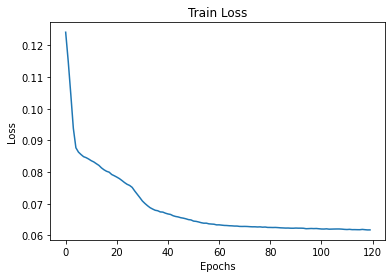

In [1237]:
plt.figure()
plt.plot(losses)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');

In [1238]:
X_test = scaler.fit_transform(cluster_gdf[feature_names])

X_test = torch.from_numpy(X_test)

test_loader = torch.utils.data.DataLoader(
    X_test, batch_size=batch_size, shuffle=False
)

recon_losses = []

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features.to(device)
        
        reconstruction = model(batch_features.float()).double()
        
        test_loss = criterion(reconstruction, batch_features)
        recon_losses.append(test_loss.item())

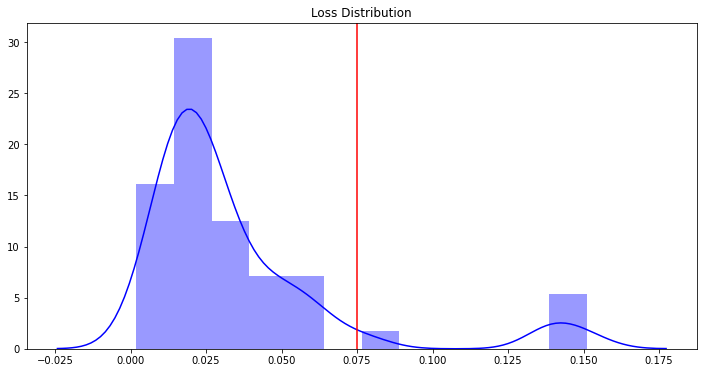

In [1243]:
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(recon_losses, kde=True, color='blue')
plt.axvline(0.075, 0.0, 10, color='r');

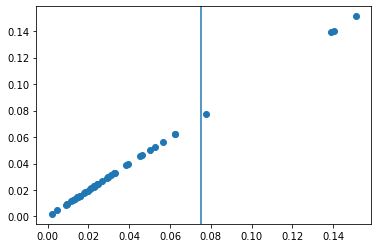

In [1244]:
loss_sc = []
for i in recon_losses:
    loss_sc.append((i,i))
plt.scatter(*zip(*loss_sc))
plt.axvline(0.075, 0.0, 1)

In [1257]:
cluster_gdf['Reconstruction Loss'] = recon_losses
cluster_gdf.sort_values('Reconstruction Loss').head()

Cluster Label                                           geometry  \
                                                                      
21            86  POLYGON ((-79.40028 43.66632, -79.40133 43.667...   
23            98  POLYGON ((-79.39759 43.64915, -79.39873 43.649...   
20            78  POLYGON ((-79.39543 43.65851, -79.39617 43.658...   
14            41  POLYGON ((-79.37831 43.65933, -79.38000 43.659...   
36           147  POLYGON ((-79.39508 43.66742, -79.39573 43.667...   

   Total Pedestrian Volume Log Total Pedestrian Volume Percentage of Venues  \
                                                       Arts & Entertainment   
21                    7851                    8.968396            16.129032   
23                   24904                   10.122784             9.803922   
20                    7722                    8.951829             3.333333   
14                   21873                    9.993008             9.625668   
36                   14885                    9.608109            14.814815   

                                                    \
         Food Nightlife Spot Outdoors & Recreation   
21  25.806452       9.677419              6.451613   
23   0.000000       3.921569              5.882353   
20  43.333333       6.666667              0.000000   
14  21.390374       6.951872              8.556150   
36  14.814815       5.555556              1.851852   

                                              Venue Count Reconstruction Loss  
   Professional & Other Places Shop & Service                                  
21                   22.580645      19.354839          31            0.001947  
23                   58.823529      21.568627          51            0.004615  
20                   23.333333      23.333333          30            0.008948  
14                   27.272727      26.203209         187            0.009236  
36                   43.518519      19.444444         108            0.009435